# FAANG Stock Analysis and Predictor

In this notebook, we are taking a look at the five most popular and best performing American technology companies: Facebook, Amazon, Apple, Netflix, and Google. In the notebook, there will be an analysis on the stock performance over five years, as well as a prediction algorithm (using machine learning) that will be run on each of the five stocks to ulimately provide a complete analysis for each asset.

### Table Of Contents

[Setup](#setup)


1. [Technical Indicators](#tech_indicators)
2. [Gather & Restructure Data](#get_data)

## Setup <a class="anchor" id="setup"></a>
In this notebook, we will be using the pandas_datareader library to acquire stock data from all 5 of the FAANG companies (Yahoo will be our source for the stock data).

_**Because there are so many technical indicators to display and we will be undergoing the same procedure for acquiring the data for all five stocks, when visualizing the results of the functions, we will use Apple's Stock as an example. This way, we will not be redundant. The same techniques can be used on all of the other stocks.**_

In [1]:
import math
from datetime import date, timedelta
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# Get the data from all of the FAANG stocks

five_years_ago = date.today() - timedelta(days=5*365)

fb_data = web.DataReader('FB', data_source='yahoo', start=five_years_ago, end=date.today())
amzn_data = web.DataReader('AMZN', data_source='yahoo', start=five_years_ago, end=date.today())
aapl_data = web.DataReader('AAPL', data_source='yahoo', start=five_years_ago, end=date.today())
nflx_data = web.DataReader('NFLX', data_source='yahoo', start=five_years_ago, end=date.today())
goog_data = web.DataReader('GOOG', data_source='yahoo', start=five_years_ago, end=date.today())

In [3]:
# Show data
aapl_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-10-26,29.532499,28.730000,29.520000,28.820000,265335200.0,26.632969
2015-10-27,29.135000,28.497499,28.850000,28.637501,279537600.0,26.464319
2015-10-28,29.825001,29.014999,29.232500,29.817499,342205600.0,27.554773
2015-10-29,30.172501,29.567499,29.674999,30.132500,204909200.0,27.845867
2015-10-30,30.305000,29.862499,30.247499,29.875000,197461200.0,27.607912
...,...,...,...,...,...,...
2020-10-19,120.419998,115.660004,119.959999,115.980003,120639300.0,115.980003
2020-10-20,118.980003,115.629997,116.199997,117.510002,124423700.0,117.510002
2020-10-21,118.709999,116.449997,116.669998,116.870003,89946000.0,116.870003


# 1. Technical Indicators <a class="anchor" id="tech_indicators"></a>
Technical Indicators are analysis tools, calculated using price and volume data, to help investors/traders understand and act on price trends. In this section, there are 12 functions that acquire 12 different technical indicators that can be used as tools to indicate whether or not an investor should buy or sell a stock.

These functions use the Pandas DataFrame data structure to execute rolling calculations of stock data for each technical indicator.

## 1.1 - Simple Moving Averages (SMA) <a class="anchor" id="sma"></a>

The first technical indicator we will calculate is the Simple Moving Average (SMA) over a specified period. An SMA calculates the average of a selected range of prices (our function uses Adjusted Closing Prices) over that same specified period. SMA's can aid in identifying price trends, and comparing multiple SMA's of varying period sizes can indicate whether or not an asset price will continue or if it will reverse a bull or bear trend.

In [4]:
# Function to get the SMA

def get_SMA(data, period):
    SMA = pd.DataFrame()
    SMA['SMA'] = data['Adj Close'].rolling(window=period).mean()
    
    return SMA

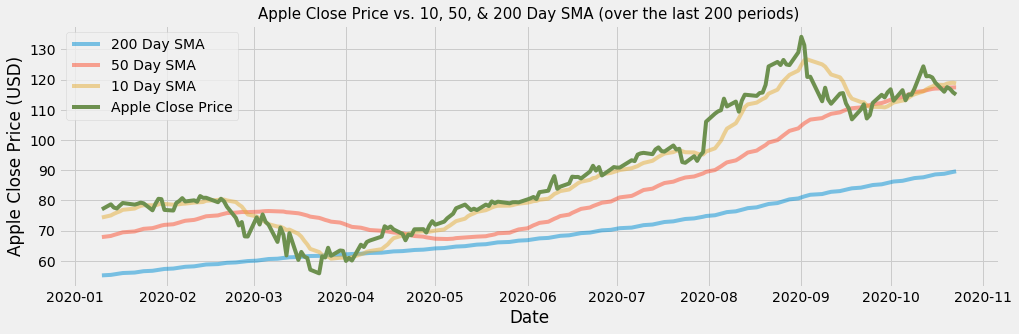

In [5]:
# Visualize the SMA data

plt.figure(figsize=(15, 4.5))
plt.title('Apple Close Price vs. 10, 50, & 200 Day SMA (over the last 200 periods)', fontsize=15)
plt.plot(get_SMA(aapl_data, 200)['SMA'].tail(200), label='200 Day SMA', alpha=0.5)
plt.plot(get_SMA(aapl_data, 50)['SMA'].tail(200), label='50 Day SMA', alpha=0.5)
plt.plot(get_SMA(aapl_data, 10)['SMA'].tail(200), label='10 Day SMA', alpha=0.5)
plt.plot(aapl_data['Adj Close'].tail(200), label='Apple Close Price')
plt.xlabel('Date')
plt.ylabel('Apple Close Price (USD)')
plt.legend(loc='upper left')
plt.show()

## 1.2 - Exponential Moving Averages (EMA)
Like the SMA's we looked at before, the Exponential Moving Average (EMA) is calculated using a selected range of Adjusted Closing Prices of a stock over a specified period. Unlike SMA's, EMA's place greater weight and significance on the most recent data points by placing an exponential weight on all of the values.

In [6]:
# Function to get the EMA

def get_EMA(data, period):
    EMA = pd.DataFrame()
    EMA['EMA'] = data['Adj Close'].ewm(span=period, adjust=False).mean()
    
    return EMA

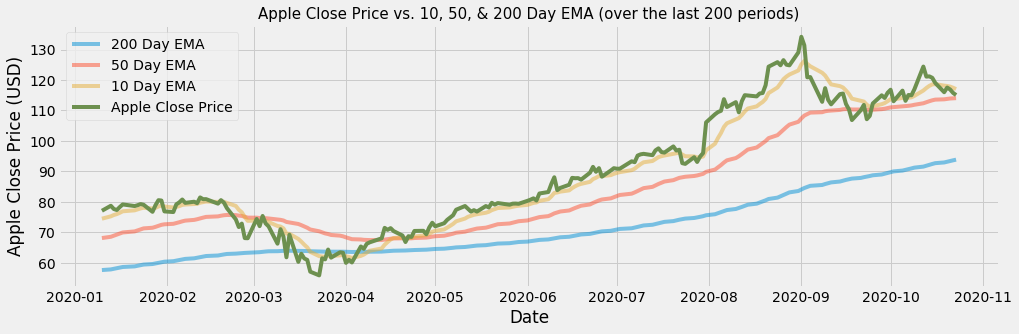

In [7]:
# Visualize the EMA data

plt.figure(figsize=(15, 4.5))
plt.title('Apple Close Price vs. 10, 50, & 200 Day EMA (over the last 200 periods)', fontsize=15)
plt.plot(get_EMA(aapl_data, 200)['EMA'].tail(200), label='200 Day EMA', alpha=0.5)
plt.plot(get_EMA(aapl_data, 50)['EMA'].tail(200), label='50 Day EMA', alpha=0.5)
plt.plot(get_EMA(aapl_data, 10)['EMA'].tail(200), label='10 Day EMA', alpha=0.5)
plt.plot(aapl_data['Adj Close'].tail(200), label='Apple Close Price')
plt.xlabel('Date')
plt.ylabel('Apple Close Price (USD)')
plt.legend(loc='upper left')
plt.show()

## 1.3 - Relative Strength Index (RSI)
The Relative Strength Index (RSI) is an indicator of a stock's current and historical weakness based on the closing prices of a period (in the case of our function, the period is 14).

The RSI is a tool that calculates momentum of price movements. RSI values range from 0 to 100, and values above 70 and below 30 indicate high levels and low levels, respectively. It provides investors with information to buy the stock when it is oversold and to sell when it is overbought.

In [8]:
# Function to get the RSI

def get_RSI(data):
    RSI = pd.DataFrame()
    RSI['Closing Prices'] = data['Adj Close']
    RSI['Change'] = RSI['Closing Prices'].diff()
    
    changes = RSI['Change'].tolist()
    
    gains = []
    losses = []
    
    for change in changes:
        if change > 0:
            gains.append(change)
            losses.append(0)
        else:
            gains.append(0)
            losses.append(-change)
    
    gains =  pd.Series(gains)
    losses = pd.Series(losses)
    
    RSI['Gains'] = gains.values
    RSI['Losses'] = losses.values
    
    RSI['Avg. Gain'] = RSI['Gains'].rolling(window=14).mean()
    RSI['Avg. Loss'] = RSI['Losses'].rolling(window=14).mean()
    
    RSI['RS'] = RSI['Avg. Gain'] / RSI['Avg. Loss']
    
    RSI['RSI'] = 100 - 100 / (1 + RSI['RS'])
    
    return RSI

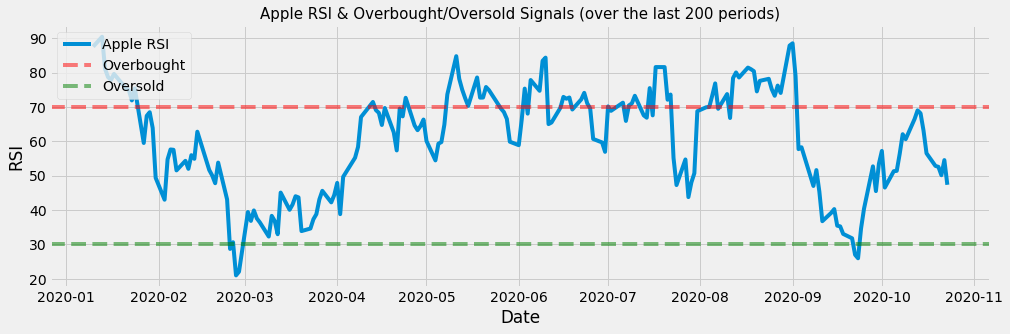

In [22]:
# Visualize the RSI data

plt.figure(figsize=(15, 4.5))
plt.title('Apple RSI & Overbought/Oversold Signals (over the last 200 periods)', fontsize=15)
plt.plot(get_RSI(aapl_data)['RSI'].tail(200), label='Apple RSI')
plt.axhline(70, linestyle='dashed', color='red', label='Overbought', alpha=0.5)
plt.axhline(30, linestyle='dashed', color='green', label='Oversold', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend(loc='upper left')
plt.show()

## 1.4 - Moving Average Convergence Divergence (MACD)
Moving Average Convergence Divergence (MACD) is a momentum indicator that shows the relationship between two EMA's of a stock's price. In this case, the function uses a 12-Day EMA as the short Moving Average and a 26-Day EMA as the long Moving Average.

The MACD Line is calculated by subtracting the Long EMA from the Short EMA. A 9-Day EMA is plotted on top of the MACD Line to indicate buy and sell signals.

In [10]:
# Function to get the MACD

def get_MACD(data):
    ShortEMA = get_EMA(data, 12)
    LongEMA = get_EMA(data, 26)
    SignalEMA = get_EMA(data, 9)
    
    MACD = pd.DataFrame()
    MACD['12 Day EMA'] = ShortEMA['EMA']
    MACD['26 Day EMA'] = LongEMA['EMA']
    
    MACD['MACD'] = MACD['12 Day EMA'] - MACD['26 Day EMA']
    MACD['Signal Line'] = SignalEMA['EMA']
    
    return MACD

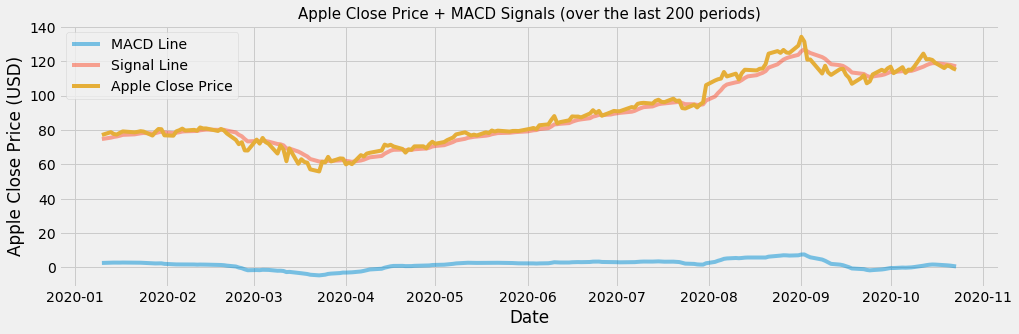

In [23]:
# Visualize the MACD data

plt.figure(figsize=(15, 4.5))
plt.title('Apple Close Price + MACD Signals (over the last 200 periods)', fontsize=15)
plt.plot(get_MACD(aapl_data)['MACD'].tail(200), label='MACD Line', alpha=0.5)
plt.plot(get_MACD(aapl_data)['Signal Line'].tail(200), label='Signal Line', alpha=0.5)
plt.plot(aapl_data['Adj Close'].tail(200), label='Apple Close Price')
plt.xlabel('Date')
plt.ylabel('Apple Close Price (USD)')
plt.legend(loc='upper left')
plt.show()

## 1.5 - Stochastic Oscillator
A Stochastic Oscillator is a momentum indicator that compares a stock's closing price to a range of its prices over a certain period (in the case of this function, the period is 14 Days). It generates a series of values, ranging from 0-100, that can indicate whether or not a stock is overbought (value > 80) or oversold (value < 20).

In [11]:
# Function to get the Stochastic Oscillator

def get_stochastic_oscillator(data):
    stoch_osc = pd.DataFrame()
    
    stoch_osc['Closing Price'] = data['Adj Close']
    stoch_osc['14 Day Low'] = stoch_osc['Closing Price'].rolling(window=14).min()
    stoch_osc['14 Day High'] = stoch_osc['Closing Price'].rolling(window=14).max()
    
    stoch_osc['Stochastic Oscillator'] = (stoch_osc['Closing Price'] - stoch_osc['14 Day Low'])
    stoch_osc['Stochastic Oscillator'] = stoch_osc['Stochastic Oscillator'] / (stoch_osc['14 Day High'] - stoch_osc['14 Day Low']) * 100
    
    return stoch_osc

## 1.6 - Bollinger Bands
A Bollinger Band is an analysis tool, using a set of trendlines, plotted two standard deviations from a SMA (period of 20 days) of a stock's price. Again, these bands are used as a momentum indicator, and can tell an investor when stocks are overbought or oversold.

In [12]:
# Function to get the Bollinger Bands

def get_bollinger_bands(data):
    period = 20  
    bollinger_bands = get_SMA(data, period)
    
    bollinger_bands['Std. Deviation'] = data['Adj Close'].rolling(window=period).std()
    
    bollinger_bands['Upper Band'] = bollinger_bands['SMA'] + (bollinger_bands['Std. Deviation'] * 2)
    bollinger_bands['Lower Band'] = bollinger_bands['SMA'] - (bollinger_bands['Std. Deviation'] * 2)
    
    return bollinger_bands

## 1.7 - Money Flow Index (MFI)
The Money Flow Index (MFI) is another example of a technical oscillator that identifies overbought and oversold signals. The MFI, however, takes both price and volume data to determine whether a stock is overbought (80 - 90 are used as thresholds) or oversold (10 - 20 are used as thresholds).

In [13]:
# Function to get the MFI

def get_MFI(data):
    MFI = pd.DataFrame()
    
    MFI['High'] = data['High']
    MFI['Close'] = data['Adj Close']
    MFI['Low'] = data['Low']
    
    MFI['Typical Price'] = (MFI['High'] + MFI['Close'] + MFI['Low']) / 3
    typ_price = MFI['Typical Price'].tolist()
    
    period = 14
    MFI['Raw MF'] = MFI['Typical Price'] * data['Volume']
    
    money_flow = MFI['Raw MF'].tolist()
    
    pos_mf = []
    neg_mf = []
    
    for i in range(len(money_flow)):
        if typ_price[i] > typ_price[i - 1]:
            pos_mf.append(money_flow[i])
            neg_mf.append(0)
        elif typ_price[i] < typ_price[i - 1]:
            pos_mf.append(0)
            neg_mf.append(money_flow[i])
        else:
            pos_mf.append(0)
            neg_mf.append(0)
    
    MFI['Positive MF'] = pd.Series(pos_mf).values
    MFI['Negative MF'] = pd.Series(neg_mf).values
    
    MFI['MF Ratio'] = MFI['Positive MF'].rolling(window=14).sum() / MFI['Negative MF'].rolling(window=14).sum()
    MFI['MFI'] = 100 - 100 / (1 + MFI['MF Ratio'])
    
    return MFI

## 1.8 - On-Balance Volume (OBV)
On-Balance Volume (OBV) is a technical trading momentum indicator that uses volume flow to predict changes in stock price. OBV can show crowd sentiment in order to predict a bullish or bearish outcome.

In [14]:
# Function to get the OBV

def get_OBV(data):
    OBV = pd.DataFrame()
    
    OBV['Volume'] = data['Volume']
    OBV['Close'] = data['Adj Close']
    
    volume = OBV['Volume'].tolist()
    closing_prices = OBV['Close'].tolist()
    
    current_OBV = []
    current_OBV.append(0)
    
    for i in range(1, len(closing_prices)):
        if closing_prices[i] > closing_prices[i-1]:
            current_OBV.append(current_OBV[i-1] + volume[i])
        elif closing_prices[i] < closing_prices[i-1]:
            current_OBV.append(current_OBV[i-1] - volume[i])
        else:
            current_OBV.append(current_OBV[i-1])
    
    OBV['OBV'] = pd.Series(current_OBV).values
    
    return OBV

## 1.9 - Accumulation/Distribution (A/D) Indicator
Accumulation/distribution is a cumulative indicator that uses volume and price to assess whether a stock is being accumulated or distributed. The accumulation/distribution measure seeks to identify divergences between the stock price and volume flow. This provides insight into how strong a trend is.

In [15]:
# Function to get A/D Indicator

def get_AD_indicator(data):
    AD = pd.DataFrame()
    
    AD['High'] = data['High']
    AD['Low'] = data['Low']
    AD['Close'] = data['Adj Close']
    AD['Volume'] = data['Volume']
    
    AD['CLV'] = (AD['Close'] - AD['Low']) - (AD['High'] - AD['Close'])
    AD['CLV'] = AD['CLV'] / (AD['High'] - AD['Low'])
    AD['CMFV'] = AD['CLV'] * AD['Volume']
    
    current_ad = []
    current_cmfv = AD['CMFV'].tolist()
    
    current_ad.append(current_cmfv[0])
    
    for i in range(1, len(current_cmfv)):
        current_ad.append(current_ad[i-1] + current_cmfv[i])
    
    AD['AD'] = pd.Series(current_ad).values
    
    return AD

## 1.10 - Average Directional Index (ADX)
The average directional index (ADX) is used to determine when the price is trending strongly. ADX is used to quantify trend strength. ADX calculations are based on a Moving Average (period is 14 Days) of price range expansion over a given period of time.

In [16]:
# Function to get ADX

def get_ADX(data):
    ADX = pd.DataFrame()
    
    ADX['High'] = data['High']
    ADX['Low'] = data['Low']
    ADX['Close'] = data['Adj Close']
    
    ADX['H - L'] = ADX['High'] - ADX['Close']
    ADX['|H - Cp|'] = (ADX['High'] - ADX['Close'].shift()).abs()
    ADX['|L - Cp|'] = (ADX['Low'] - ADX['Close'].shift()).abs()
    ADX['TR'] = ADX[['H - L', '|H - Cp|', '|L - Cp|']].max(axis=1)
    
    pos_dm1 = (ADX['High'] - ADX['High'].shift()).tolist()
    neg_dm1 = ((ADX['Low'] - ADX['Low'].shift()).abs()).tolist()
    
    for i in range(1, len(pos_dm1)):
        if pos_dm1[i] > neg_dm1[i]:
            neg_dm1[i] = 0
        else:
            pos_dm1[i] = 0
    
    ADX['+DM1'] = pd.Series(pos_dm1).values
    ADX['-DM1'] = pd.Series(neg_dm1).values
    
    ADX['TR14'] = ADX['TR'].rolling(window=14).sum()
    ADX['TR14'] = ADX['TR14'] - (ADX['TR14'] / 14) + ADX['TR']
    
    ADX['+DM14'] = ADX['+DM1'].rolling(window=14).sum()
    ADX['+DM14'] = ADX['+DM14'] - (ADX['+DM14'] / 14) + ADX['+DM1']
    
    ADX['-DM14'] = ADX['-DM1'].rolling(window=14).sum()
    ADX['-DM14'] = ADX['-DM14'] - (ADX['-DM14'] / 14) + ADX['-DM1']
    
    ADX['+DI14'] = (ADX['+DM14'] / ADX['TR14']) * 100
    ADX['-DI14'] = (ADX['-DM14'] / ADX['TR14']) * 100
    
    ADX['DX'] = (((ADX['+DI14'] - ADX['-DI14']).abs()) / (ADX['+DI14'] + ADX['-DI14'])) * 100
    ADX['ADX'] = ADX['DX'].rolling(window=14).mean()
    ADX['ADX'] = ((ADX['ADX'] * 13) + ADX['DX']) / 14
    
    return ADX

## 1.11 - Aroon Oscillator
The Aroon indicator is a technical indicator that is used to identify trend changes in the price of an asset, as well as the strength of that trend. In essence, the indicator measures the time between highs and the time between lows over a time period.

The indicator consists of the "Aroon Up" line, which measures the strength of the uptrend, and the "Aroon Down" line, which measures the strength of the downtrend.

In [17]:
def get_aroon_osc(data):
    aroon_osc = pd.DataFrame()
    
    period = 25
    
    aroon_osc['High'] = data['High']
    aroon_osc['Low'] = data['Low']
    aroon_osc['25 Day High'] = aroon_osc['High'].rolling(window=25).max()
    aroon_osc['25 Day Low'] = aroon_osc['Low'].rolling(window=25).max()
    
    for i in range(period, -1, -1):
        aroon_osc.loc[aroon_osc['High'].shift(i) == aroon_osc['25 Day High'], 'Periods Since 25 Day High'] = i
        aroon_osc.loc[aroon_osc['Low'].shift(i) == aroon_osc['25 Day Low'], 'Periods Since 25 Day Low'] = i
    
    aroon_osc['Aroon Up'] = 100 * ((25 - aroon_osc['Periods Since 25 Day High']) / 25)
    aroon_osc['Aroon Down'] = 100 * ((25 - aroon_osc['Periods Since 25 Day Low']) / 25)
    
    aroon_osc['Aroon Osc'] = aroon_osc['Aroon Up'] - aroon_osc['Aroon Down']
    
    return aroon_osc

## 1.12 - Price Rate of Change (ROC)
The Price Rate of Change (ROC) is a momentum-based technical indicator that measures the percentage change in price between the current price and the price a certain number of periods ago. The ROC indicator is plotted against zero, with the indicator moving upwards into positive territory if price changes are to the upside, and moving into negative territory if price changes are to the downside.

In [18]:
# Function to get the ROC indicator

def get_ROC(data, period):
    ROC = pd.DataFrame()
    
    ROC['Close'] = data['Adj Close']
    ROC['Close from n Periods Ago'] = ROC['Close'].shift(period)
    
    ROC['ROC'] = ((ROC['Close'] - ROC['Close from n Periods Ago']) / ROC['Close from n Periods Ago']) * 100
    
    return ROC

# 2. Gather & Restructure Data <a class="anchor" id="get_data"></a>
Before visualizing and analyzing the data, we must add all of the necessary data from both the original data and technical indicator data to one single DataFrame.

In [25]:
# Function to call all of the technical indicator functions and structure the necessary data into 1 Pandas
#  DataFrame

def gather_all_data(data):
    df = pd.DataFrame()
    
    # Gather necessary data from original df
    df['Adj Close'] =  data['Adj Close']
    df['High'] = data['High']
    df['Low'] = data['Low']
    df['Volume'] = data['Volume']
    
    
    # Get technical indicator data
    df['SMA5'] = get_SMA(data, 5)['SMA']
    df['SMA50'] = get_SMA(data, 50)['SMA']
    df['SMA200'] = get_SMA(data, 200)['SMA']
    
    df['EMA5'] = get_EMA(data, 5)['EMA']
    df['EMA50'] = get_EMA(data, 50)['EMA']
    df['EMA200'] = get_EMA(data, 200)['EMA']
    
    df['RSI'] = get_RSI(data)['RSI']
    
    df['MACD Line'] = get_MACD(data)['MACD']
    df['MACD Signal'] = get_MACD(data)['Signal Line']
    
    df['Stochastic Osc.'] = get_stochastic_oscillator(data)['Stochastic Oscillator']
    
    df['BB Upper Band'] = get_bollinger_bands(data)['Upper Band']
    df['BB Lower Band'] = get_bollinger_bands(data)['Lower Band']
    
    df['MFI'] = get_MFI(data)['MFI']
    
    df['OBV'] = get_OBV(data)['OBV']
    
    df['A/D Indicator'] = get_AD_indicator(data)['AD']
    
    df['ADX'] = get_ADX(data)['ADX']
    
    df['Aroon Osc'] = get_aroon_osc(data)['Aroon Osc']
    
    df['12 Day ROC'] = get_ROC(data, 12)['ROC']
    
    
    return df

In [20]:
# Create the master DataFrames to store our final data and call gather_all_data function for each stock

fb_df = gather_all_data(fb_data)
aapl_df = gather_all_data(aapl_data)
amzn_df = gather_all_data(amzn_data)
nflx_df = gather_all_data(nflx_data)
goog_df = gather_all_data(goog_data)

In [21]:
# Show data
aapl_df

,Adj Close,High,Low,Volume,SMA5,SMA50,SMA200,EMA5,EMA50,EMA200,...,MACD Signal,Stochastic Osc.,BB Upper Band,BB Lower Band,MFI,OBV,A/D Indicator,ADX,Aroon Osc,12 Day ROC
Date,,,,,,,,,,,,,,,,,,,,,
2015-10-26,26.632969,29.532499,28.730000,265335200.0,NaN,NaN,NaN,26.632969,26.632969,26.632969,...,26.632969,NaN,NaN,NaN,NaN,0.000000e+00,-1.652042e+09,NaN,NaN,NaN
2015-10-27,26.464319,29.135000,28.497499,279537600.0,NaN,NaN,NaN,26.576752,26.626355,26.631291,...,26.599239,NaN,NaN,NaN,NaN,-2.795376e+08,-3.714638e+09,NaN,NaN,NaN
2015-10-28,27.554773,29.825001,29.014999,342205600.0,NaN,NaN,NaN,26.902759,26.662764,26.640480,...,26.790346,NaN,NaN,NaN,NaN,6.266800e+07,-5.290662e+09,NaN,NaN,NaN
2015-10-29,27.845867,30.172501,29.567499,204909200.0,NaN,NaN,NaN,27.217129,26.709160,26.652474,...,27.001450,NaN,NaN,NaN,NaN,2.675772e+08,-6.661778e+09,NaN,NaN,NaN
2015-10-30,27.607912,30.305000,29.862499,197461200.0,27.221168,NaN,NaN,27.347390,26.744405,26.661980,...,27.122742,NaN,NaN,NaN,NaN,7.011600e+07,-8.871408e+09,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-19,115.980003,120.419998,115.660004,120639300.0,119.600000,117.122699,88.809774,118.532430,113.646099,92.917008,...,118.288864,26.010593,124.226955,107.091045,45.164659,4.971667e+09,-7.331933e+11,52.819979,0.0,-0.693550
2020-10-20,117.510002,118.980003,115.629997,124423700.0,118.882001,117.218349,89.025142,118.191621,113.797624,93.161714,...,118.133091,39.455216,124.350560,107.537441,44.713659,5.096090e+09,-7.331780e+11,50.055642,0.0,3.972753
2020-10-21,116.870003,118.709999,116.449997,89946000.0,118.018001,117.368250,89.239060,117.751082,113.918110,93.397617,...,117.880474,33.831322,123.742992,109.120009,39.309624,5.006144e+09,-7.332345e+11,46.413051,0.0,0.317599
